In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.io import loadmat

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def plot_stim_and_spikes(stim, spikes, dt, nt=120):
    """Affiche les séries temporelles de l'intensité du stimulus et du nombre de spikes.
    Args:
        stim (1D array): vecteur des intensités de stimulus
        spikes (1D array): vecteur des comptes de spikes
        dt (number): durée de chaque pas de temps
        nt (number): nombre de pas de temps à tracer
    """
    timepoints = np.arange(nt)
    time = timepoints * dt
    f, (ax_stim, ax_spikes) = plt.subplots(
        nrows=2, sharex=True, figsize=(8, 5),
    )
    ax_stim.plot(time, stim[timepoints])
    ax_stim.set_ylabel('Intensité du stimulus')
    ax_spikes.plot(time, spikes[timepoints])
    ax_spikes.set_xlabel('Temps (s)')
    ax_spikes.set_ylabel('Nombre de spikes')
    f.tight_layout()
    plt.show()

def plot_glm_matrices(X, y, nt=50):
    """Affiche X et Y sous forme de heatmaps.
    Args:
        X (2D array): Matrice de conception.
        y (1D or 2D array): Vecteur cible.
    """
    from matplotlib.colors import BoundaryNorm
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    Y = np.c_[y]  # Assure que Y est en 2D et étroit
    f, (ax_x, ax_y) = plt.subplots(
        ncols=2,
        figsize=(6, 8),
        sharey=True,
        gridspec_kw=dict(width_ratios=(5, 1)),
    )
    norm = BoundaryNorm([-1, -.2, .2, 1], 256)
    imx = ax_x.pcolormesh(X[:nt], cmap="coolwarm", norm=norm)
    ax_x.set(
        title="X\n(stimulus retardé)",
        xlabel="Retard temporel (bins de temps)",
        xticks=[4, 14, 24],
        xticklabels=['-20', '-10', '0'],
        ylabel="Point temporel (bins de temps)",
    )
    plt.setp(ax_x.spines.values(), visible=True)
    divx = make_axes_locatable(ax_x)
    caxx = divx.append_axes("right", size="5%", pad=0.1)
    cbarx = f.colorbar(imx, cax=caxx)
    cbarx.set_ticks([-.6, 0, .6])
    cbarx.set_ticklabels(np.sort(np.unique(X)))
    norm = BoundaryNorm(np.arange(y.max() + 1), 256)
    imy = ax_y.pcolormesh(Y[:nt], cmap="magma", norm=norm)
    ax_y.set(
        title="Y\n(compte de spikes)",
        xticks=[]
    )
    ax_y.invert_yaxis()
    plt.setp(ax_y.spines.values(), visible=True)
    divy = make_axes_locatable(ax_y)
    caxy = divy.append_axes("right", size="30%", pad=0.1)
    cbary = f.colorbar(imy, cax=caxy)
    cbary.set_ticks(np.arange(y.max()) + .5)
    cbary.set_ticklabels(np.arange(y.max()))
    plt.show()

def plot_spike_filter(theta, dt, show=True, **kws):
    """Trace les poids estimés basés sur le modèle de retard temporel.
    Args:
        theta (1D array): Poids du filtre, sans inclure le terme DC.
        dt (number): Durée de chaque bin de temps.
        kws: Passer des arguments supplémentaires à plot()
        show (boolean): Afficher ou non le plot.
    """
    d = len(theta)
    t = np.arange(-d + 1, 1) * dt
    ax = plt.gca()
    ax.plot(t, theta, marker="o", **kws)
    ax.axhline(0, color=".2", linestyle="--", zorder=1)
    ax.set(
        xlabel="Temps avant le spike (s)",
        ylabel="Poids du filtre",
    )
    if show:
        plt.show()

def plot_spikes_with_prediction(spikes, predicted_spikes, dt,
                                nt=50, t0=120, **kws):
    """Trace les comptes de spikes réels et prédits.
    Args:
        spikes (1D array): Vecteur des comptes de spikes réels
        predicted_spikes (1D array): Vecteur des comptes de spikes prédits
        dt (number): Durée de chaque bin de temps.
        nt (number): Nombre de bins de temps à tracer
        t0 (number): Index du premier bin de temps à tracer.
        show (boolean): Afficher ou non le plot.
        kws: Passer des arguments supplémentaires à plot()
    """
    t = np.arange(t0, t0 + nt) * dt
    f, ax = plt.subplots()
    lines = ax.stem(t, spikes[:nt])
    plt.setp(lines, color=".5")
    lines[-1].set_zorder(1)
    kws.setdefault("linewidth", 3)
    yhat, = ax.plot(t, predicted_spikes[:nt], **kws)
    ax.set(
        xlabel="Temps (s)",
        ylabel="Spikes",
    )
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.legend([lines[0], yhat], ["Spikes", "Prédits"])
    plt.show()


In [23]:
import os
import hashlib
import requests

fname = "RGCdata.mat"
url = "https://osf.io/mzujs/download"
expected_md5 = "1b2977453020bce5319f2608c94d38d0"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        elif hashlib.md5(r.content).hexdigest() != expected_md5:
            print("!!! Data download appears corrupted !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)


Section 1: Modèle Linéaire-Gaussien GLM

Section 1.1: Charger les données d'activité des cellules ganglionnaires rétiniennes

In [24]:
data = loadmat('RGCdata.mat')  # loadmat est une fonction de scipy.io
dt_stim = data['dtStim'].item()  # .item extrait une valeur scalaire

# Extraire l'intensité du stimulus
stim = data['Stim'].squeeze()  # .squeeze supprime les dimensions avec un seul élément

# Extraire les comptes de spikes pour une cellule
cellnum = 2
spikes = data['SpCounts'][:, cellnum]

# Ne pas utiliser tous les points temporels du jeu de données, pour la rapidité
keep_timepoints = 20000
stim = stim[:keep_timepoints]
spikes = spikes[:keep_timepoints]


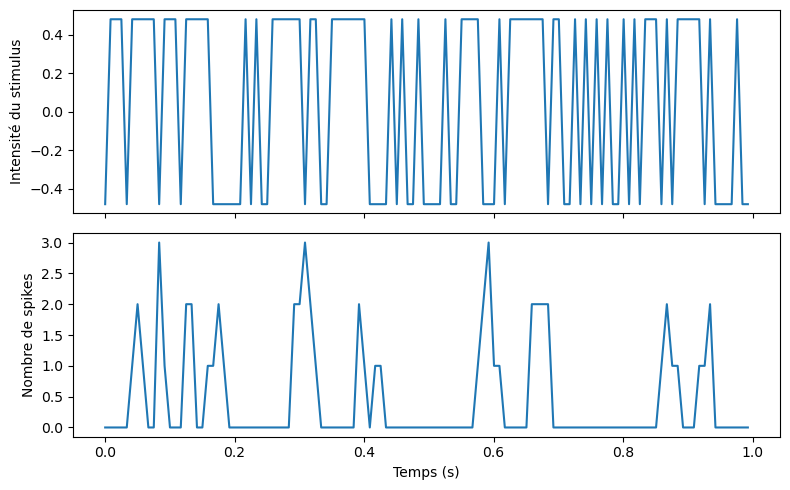

In [25]:
plot_stim_and_spikes(stim, spikes, dt_stim)


Question

Cellule 0


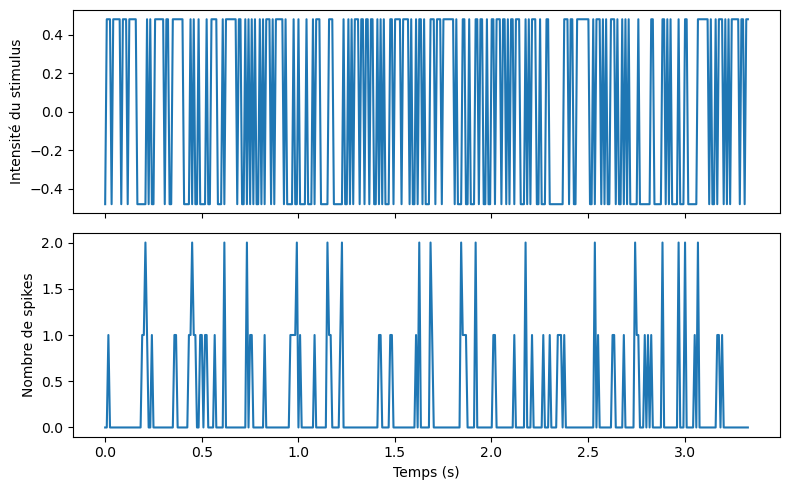

Cellule 1


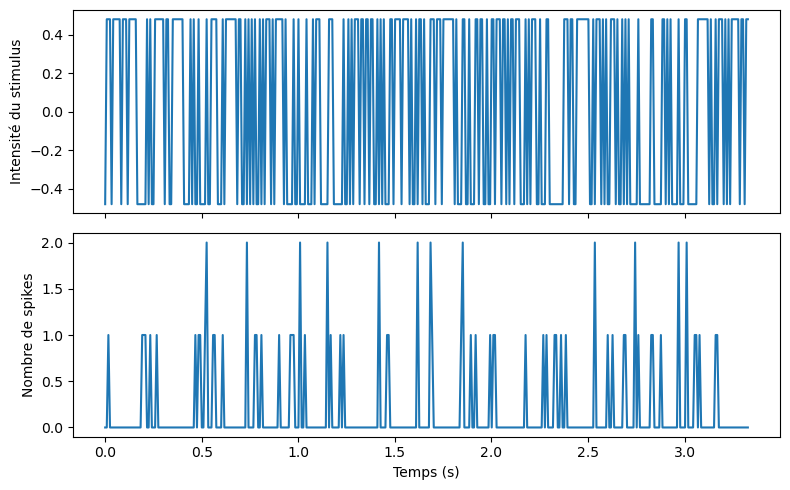

Cellule 2


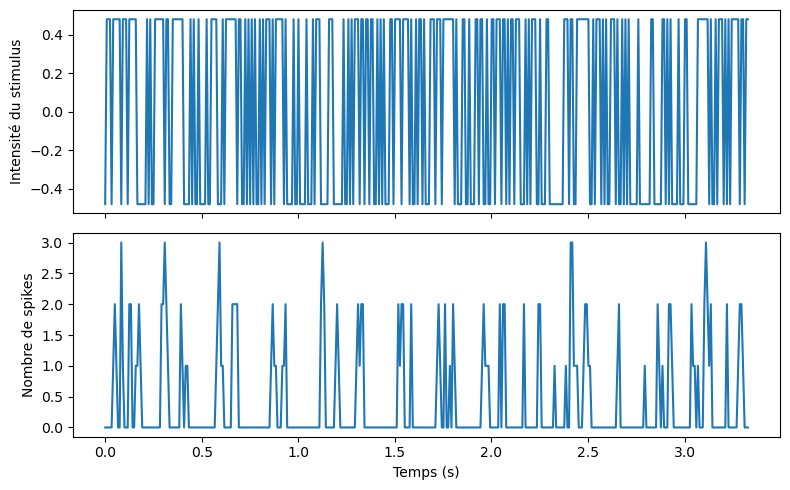

In [42]:
nt = 400  
for cellnum in range(3):
    spikes = data['SpCounts'][:keep_timepoints, cellnum]
    print(f"Cellule {cellnum}")
    plot_stim_and_spikes(stim, spikes, dt_stim, nt=nt)


Que constatez-vous ?

Certaines cellules deviennent actives quand la lumière augmente : ce sont les cellules ON.
D’autres deviennent actives quand la lumière baisse : ce sont les cellules OFF.

Pour un même changement de lumière :

Les cellules ON réagissent quand la lumière devient forte.

Les cellules OFF réagissent quand la lumière devient faible.

Exercice de Codage 1.1 : Créer une matrice de conception

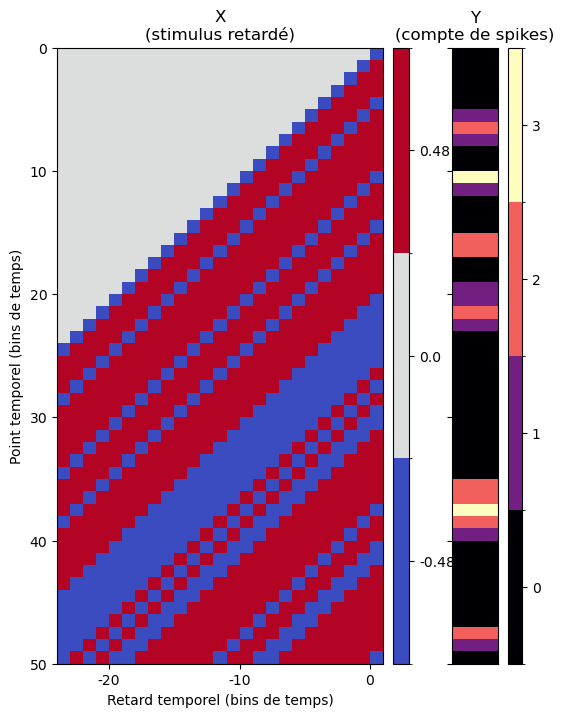

In [44]:
import numpy as np

def make_design_matrix(stim, d=25):
    """Crée une matrice de conception avec décalage temporel à partir du vecteur d'intensité de stimulus.
    Args:
        stim (1D array): Intensité du stimulus à chaque point temporel.
        d (number): Nombre de décalages temporels à utiliser.
    Returns:
        X (2D array): Matrice de conception GLM avec la forme (T, d)
    """
    # Créer une version du vecteur de stimulus avec des zéros avant le début
    padded_stim = np.concatenate([np.zeros(d - 1), stim])

    # Nombre total de points temporels
    T = len(stim)

    # Initialiser la matrice de conception
    X = np.zeros((T, d))

    # Remplir chaque ligne avec les d valeurs précédentes du stimulus
    for t in range(T):
        X[t] = padded_stim[t : t + d]

    return X

# Créer la matrice de conception
X = make_design_matrix(stim)
# Visualiser
plot_glm_matrices(X, spikes, nt=50)


Section 1.2 : Ajustement du modèle de régression linéaire gaussien

In [29]:
# Construire la matrice de conception complète
y = spikes
constant = np.ones_like(y)
X = np.column_stack([constant, make_design_matrix(stim)])
# Obtenir les poids MLE pour le modèle LG
theta = np.linalg.inv(X.T @ X) @ X.T @ y
theta_lg = theta[1:]

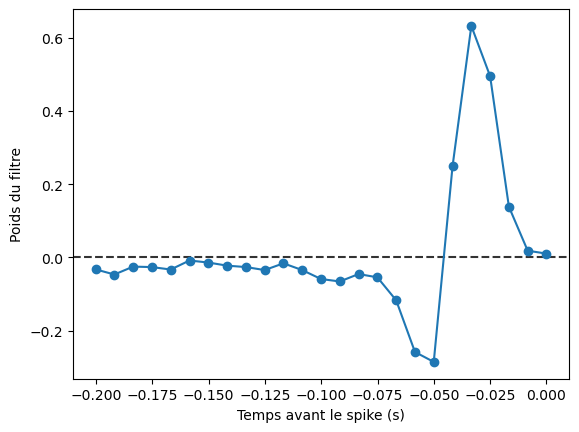

In [30]:
plot_spike_filter(theta_lg, dt_stim) 

question


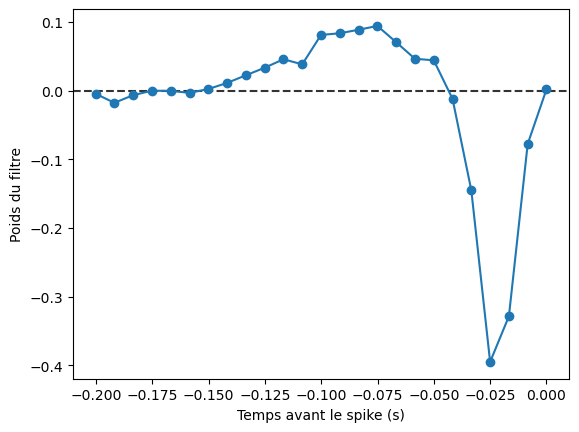

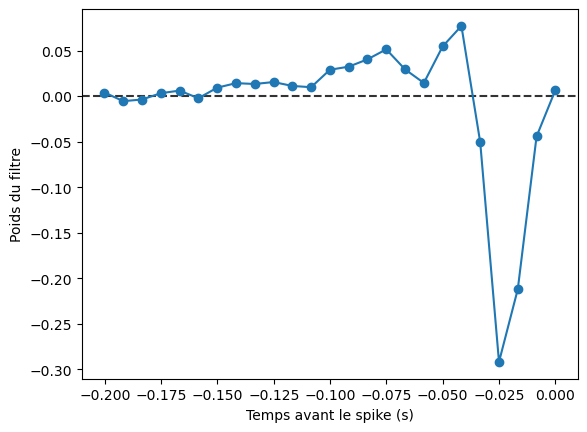

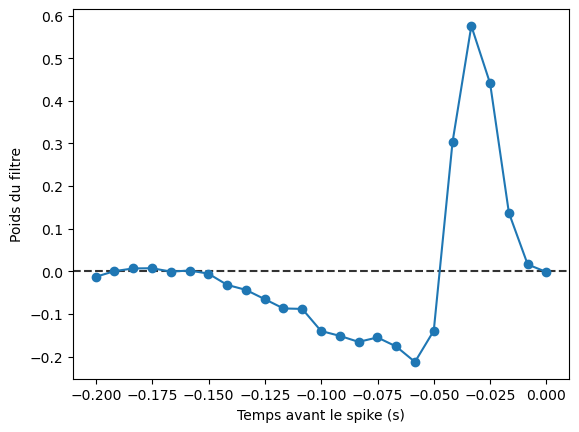

In [31]:
for cellnum in range(3):
    y = data['SpCounts'][:keep_timepoints, cellnum]
    X = np.column_stack([np.ones_like(y), make_design_matrix(stim, d=25)])
    theta = np.linalg.inv(X.T @ X) @ X.T @ y
    spike_filter = theta[1:]
    plot_spike_filter(spike_filter, dt_stim, label=f'Cellule {cellnum}')


In [32]:
#1-filtre negative -off
#2-filtre positive -on
#3-filtre positive -on

Exercice de Codage 1.2 : Prédire les comptes de spikes avec le modèle Linéaire-Gaussien

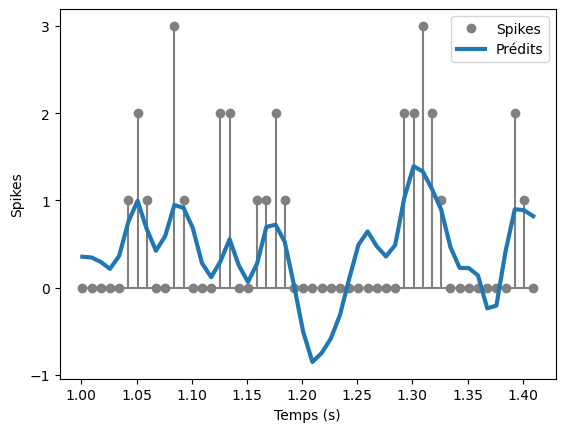

In [45]:
import numpy as np

def predict_spike_counts_lg(stim, spikes, d=25):
    """Calcule un vecteur de comptes de spikes prédits à partir du stimulus.
    Args:
        stim (1D array): Valeurs de stimulus à chaque point temporel
        spikes (1D array): Comptes de spikes mesurés à chaque point temporel
        d (number): Nombre de décalages temporels à utiliser.
    Returns:
        yhat (1D array): Spikes prédits à chaque point temporel.
    """
    # Créer la matrice de conception
    y = spikes
    constant = np.ones_like(y)
    X_design = make_design_matrix(stim, d)
    X = np.column_stack([constant, X_design])

    # Obtenir les poids MLE pour le modèle LG
    theta = np.linalg.inv(X.T @ X) @ X.T @ y

    # Calculer les comptes de spikes prédits
    yhat = X @ theta
    return yhat
# Prédire les comptes de spikes
predicted_counts = predict_spike_counts_lg(stim, spikes)
# Visualiser
plot_spikes_with_prediction(spikes, predicted_counts, dt_stim)


Cette affirmation repose sur le fait que le stimulus est du bruit blanc.

Si c’est vrai, alors les valeurs du stimulus à différents instants sont indépendantes. Cela signifie que les colonnes de la matrice de conception X (stimulus retardé) ne sont pas corrélées.

Question 1-


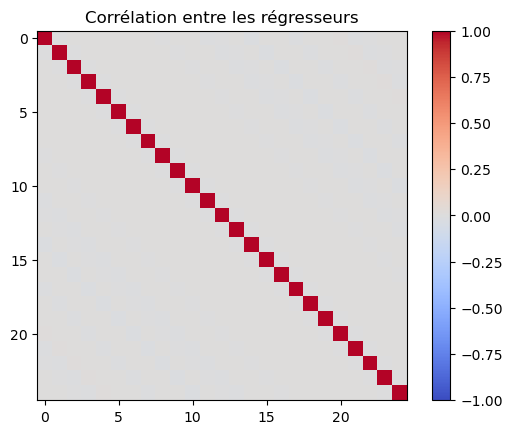

In [34]:
X_design = make_design_matrix(stim, d=25)
correlation_matrix = np.corrcoef(X_design.T)
plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Corrélation entre les régresseurs")
plt.colorbar()
plt.show()

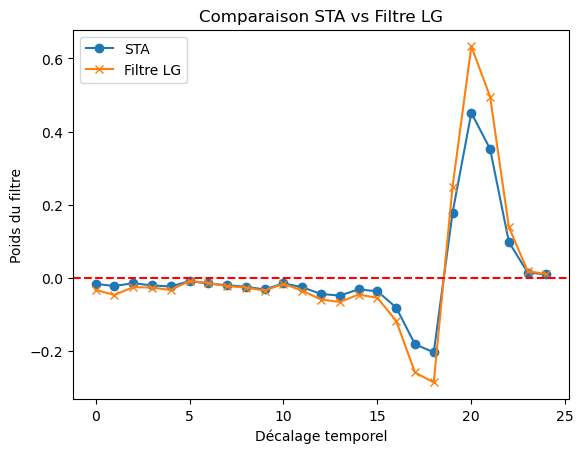

In [35]:
STA = X_design.T @ spikes / np.sum(spikes)
X = np.column_stack([np.ones_like(spikes), X_design])
theta_lg = np.linalg.inv(X.T @ X) @ X.T @ spikes
filter_lg = theta_lg[1:] 
X = np.column_stack([np.ones_like(spikes), X_design])
theta_lg = np.linalg.inv(X.T @ X) @ X.T @ spikes
filter_lg = theta_lg[1:]  
plt.plot(STA, label='STA', marker='o')
plt.plot(filter_lg, label='Filtre LG', marker='x')
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.title("Comparaison STA vs Filtre LG")
plt.xlabel("Décalage temporel")
plt.ylabel("Poids du filtre")
plt.show()

Si le stimulus est vraiment du bruit blanc, alors le filtre STA et le filtre LG (GLM gaussien) seront presque identiques.

L’absence de corrélation implique que l’inversion dans la solution LG n’apporte aucune correction supplémentaire.

Section 2 : Modèle Linéaire-Non Linéaire-Poisson GLM

Section 2.1 : Optimisation non linéaire avec scipy.optimize

In [36]:
f = np.square
res = minimize(f, x0=2)
print(f"Minimum value: {res['fun']:.4g} at x = {res['x'].item():.5e}")

Minimum value: 3.566e-16 at x = -1.88846e-08


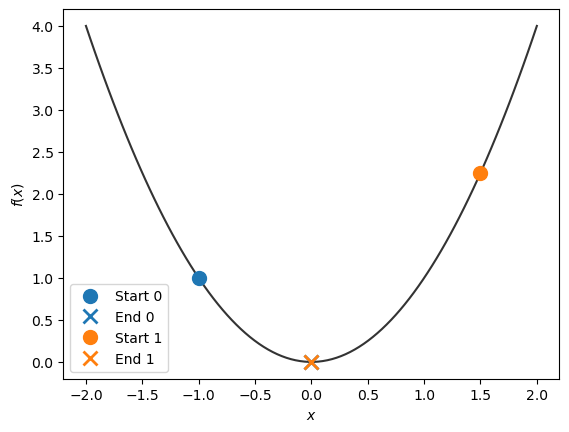

In [37]:
start_points = -1, 1.5

xx = np.linspace(-2, 2, 100)
plt.plot(xx, f(xx), color=".2")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

for i, x0 in enumerate(start_points):
  res = minimize(f, x0)
  plt.plot(x0, f(x0), "o", color=f"C{i}", ms=10, label=f"Start {i}")
  plt.plot(res["x"].item(), res["fun"], "x", c=f"C{i}",
           ms=10, mew=2, label=f"End {i}")
plt.legend()
plt.show()

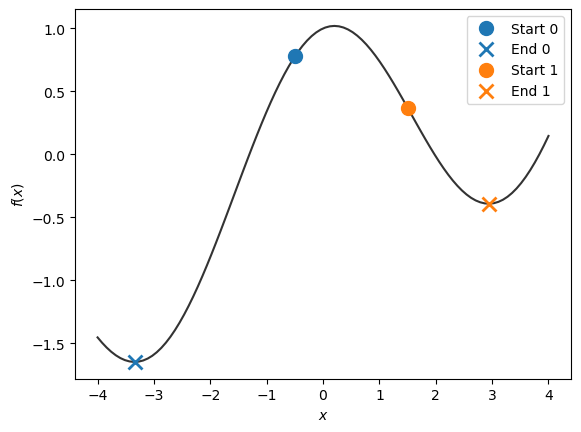

In [38]:
g = lambda x: x / 5 + np.cos(x)
start_points = -.5, 1.5

xx = np.linspace(-4, 4, 100)
plt.plot(xx, g(xx), color=".2")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

for i, x0 in enumerate(start_points):
  res = minimize(g, x0)
  plt.plot(x0, g(x0), "o", color=f"C{i}", ms=10, label=f"Start {i}")
  plt.plot(res["x"].item(), res["fun"], "x", color=f"C{i}",
           ms=10, mew=2, label=f"End {i}")
plt.legend()
plt.show()

Exercice de Codage 2.1 : Ajuster le modèle Poisson GLM et prédire les spikes

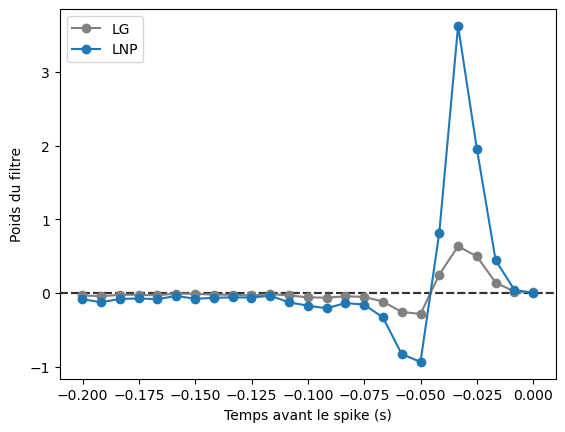

In [39]:
def neg_log_lik_lnp(theta, X, y):
   
    rate = np.exp(X @ theta)
    log_lik = y @ np.log(rate) - np.sum(rate)
    return -log_lik 

def fit_lnp(stim, spikes, d=25):
    
    y = spikes
    constant = np.ones_like(y)
    X = np.column_stack([constant, make_design_matrix(stim)])
    # Utiliser un vecteur aléatoire de poids pour commencer (moyenne 0, écart-type .2)
    theta_0 = np.random.normal(0, .2, d + 1)
    # Trouver les paramètres qui minimisent la fonction de log-vraisemblance négative
    res = minimize(neg_log_lik_lnp, theta_0, args=(X, y), method='BFGS')
    return res.x

# Ajuster le modèle LNP
theta_lnp = fit_lnp(stim, spikes)
# Visualiser
plot_spike_filter(theta_lg[1:], dt_stim, show=False, color=".5", label="LG")
plot_spike_filter(theta_lnp[1:], dt_stim, show=False, label="LNP")
plt.legend(loc="upper left")
plt.show()



Question

Pour rendre l’affirmation quantitative, on peut comparer les performances du modèle LNP avec une mesure chiffrée plutôt que juste visuelle :

Log-vraisemblance : calculer la log-vraisemblance des données sous le modèle LNP et éventuellement d’autres modèles. Plus la log-vraisemblance est élevée, meilleur est l’ajustement.

Validation croisée : séparer les données en ensembles d’entraînement et de test, puis mesurer l’erreur de prédiction (par exemple, la différence entre les spikes observés et les taux prévus par le modèle).